In [1]:
import numpy as np
import torch
import torch.nn as nn
import lightning.pytorch as pl
import torchmetrics
from IPython.display import display

import pandas as pd
import matplotlib.pyplot as plt
import plotly.offline as py

from sklearn.preprocessing import MinMaxScaler

from torch.utils.data import DataLoader, TensorDataset

# Helper Classes
from App_Data_Processor import Data_Processor
from App_LSTM_Model import LSTM_Model

In [2]:
# Model & Learning Config
cfg_split         = 0.8
cfg_input_size    = 1
cfg_num_layers    = 4
cfg_hidden_size   = 50
cfg_dropout       = 0.1
cfg_learning_rate = 0.001
model             = LSTM_Model(input_size=cfg_input_size,
                               num_layers=cfg_num_layers,
                               hidden_size=cfg_hidden_size,
                               dropout=cfg_dropout,
                               learning_rate=cfg_learning_rate)

# Data Config
cfg_seq_len       = 90
cfg_data_date_fmt = "%Y-%m-%d"
cfg_data_url      = "https://s3.amazonaws.com/mtsu.csci.7850.project/train.csv"
cfg_model_url     = "https://s3.amazonaws.com/mtsu.csci.7850.project/lstm-model-2023-12-13.pth"
data_processor    = Data_Processor(seq_length=cfg_seq_len)

# Trainer Config
cfg_batch_size  = 50
cfg_max_epochs  = 10
cfg_num_workers = 2

# Logger Config
cfg_logger_dir     = "logs"
cfg_logger_name    = "LSTM-Project"
cfg_logger_version = "v1.0.0"


In [3]:
# Setup CPU or GPU Device Settings for CUDA
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())
    print(torch.cuda.get_device_properties("cuda"))
    print("Number of devices:",torch.cuda.device_count())
    device = ("cuda")
else:
    print("Only CPU is available...")
    device = ("cpu")

Only CPU is available...


In [4]:
# Load Data - Parse the Date Column
data_processor.load_data(url=cfg_data_url, date_fmt=cfg_data_date_fmt)

# Get Raw & Avg Sales Dataframes
df_sales_raw = data_processor.df_sales_raw
df_sales_avg = data_processor.df_sales_avg

# Scale the Dataframe
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_sales_data = scaler.fit_transform(data_processor.sales_raw)
scaled_sales_data_avg = scaler.fit_transform(data_processor.sales_avg)


In [5]:
# Preprocess the historical data
x, y = data_processor.create_sequences(scaled_sales_data_avg)

# Split the data into training and testing sets
train_size = int(len(y) * cfg_split)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()


In [6]:
xy_train = torch.utils.data.DataLoader(list(zip(torch.Tensor(x_train).float(),
                                                torch.Tensor(y_train).float())), 
                                       shuffle=True, 
                                       batch_size=cfg_batch_size, 
                                       num_workers=cfg_num_workers)

xy_test = torch.utils.data.DataLoader(list(zip(torch.Tensor(x_test).float(), 
                                              torch.Tensor(y_test).float())), 
                                     shuffle=False, 
                                     batch_size=cfg_batch_size, 
                                     num_workers=cfg_num_workers)


logger = pl.loggers.CSVLogger("lstm-logger", 
                              name="LSTM-Project",
                              version="1.0.0")

In [7]:
trainer = pl.Trainer(logger=logger, 
                     max_epochs=cfg_max_epochs,
                     enable_progress_bar=True,
                     log_every_n_steps=0,
                     enable_checkpointing=False, 
                     callbacks=[pl.callbacks.TQDMProgressBar(refresh_rate=50)])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [8]:
trainer.validate(model, xy_test)

/opt/conda/lib/python3.11/site-packages/lightning/fabric/loggers/csv_logs.py:195: UserWarning:

Experiment logs directory lstm-logger/LSTM-Project/1.0.0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!

/opt/conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning:

The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    0.2858045995235443     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.2858045995235443}]

In [9]:
state_dict = torch.hub.load_state_dict_from_url(cfg_model_url)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [10]:
trainer.validate(model, xy_test)

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │   0.005103602074086666    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.005103602074086666}]

In [11]:
# Take the last datapoints from the Test Data
starting_tensor = x_test[-1:]
input_tensor = starting_tensor

# Fore Cast Array to Plot
forecast_array = np.array([])

for i in range(90):
    output = model(input_tensor)
    forecast = output.item()
    forecast_array = np.append(forecast_array, forecast)
    if output.dim() == 2:
        output = output.unsqueeze(0)  # Adds a batch dimension
    combined = torch.cat((input_tensor, output), dim=1)
    result = combined[:, 1:, :]


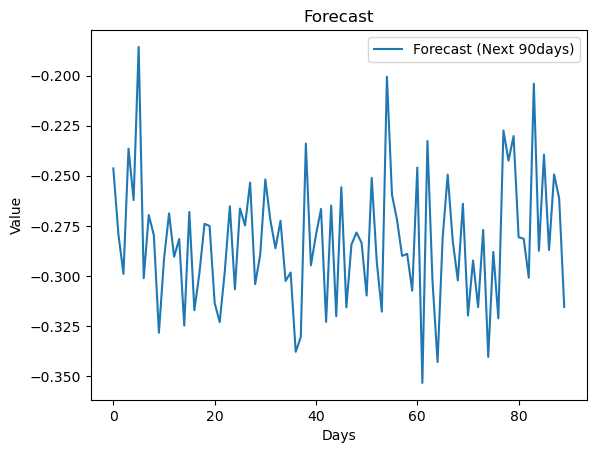

In [12]:
# Plot the next 90days forecast predictions
plt.plot(forecast_array, label="Forecast (Next 90days)")
plt.xlabel("Days")
plt.ylabel("Value")
plt.legend()
plt.title("Forecast")
plt.show()